# Day 19
I've heard analysts talk about the 2022 NFL Season being boring and/or low scoring. One metric we can look at is win margin, which is calculated as winning team's points - losing team's points. I want to see how the average win margin of games through Week 9 stacks up against previous seasons. If there is a significant difference in close games, maybe that can help to build a case that this NFL season isn't the most entertaining from an offensive standpoint.

## Set Up

In [7]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Get the data

In [9]:
query = """
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin
    FROM schedules 
    WHERE week <= 9
        AND game_type = 'REG'
)
SELECT *
FROM data
"""

df = pd.read_sql(query, conn)
df.head()

,season,week,win_margin
0,1999,1,3.0
1,1999,1,3.0
2,1999,1,43.0
3,1999,1,4.0
4,1999,1,17.0


In [10]:
by_season = df.groupby('season').mean()

In [11]:
by_season.sort_values('win_margin', ascending=False).round(2)

,week,win_margin
season,,
2009,4.79,13.52
2014,4.89,12.73
2007,4.83,12.21
2008,4.89,12.01
2003,4.89,11.85
2006,4.87,11.70
2005,4.89,11.65
2017,4.84,11.63
2011,4.80,11.61


In [12]:
by_season.describe()

,week,win_margin
count,24.000000,24.000000
mean,4.865124,11.344781
std,0.047904,0.867036
min,4.790698,9.426471
25%,4.829844,11.049069
50%,4.858718,11.294531
75%,4.892308,11.664213
max,4.984375,13.519380


In [13]:
by_season['win_margin'].quantile(0.25) - (1.5 * stats.iqr(by_season['win_margin']))

10.12635216346154

Based on this the win margin for 2022 is an outlier. At an average of 9.42 points over the first 9 weeks, it's less than the threshold of 1.5 * IQR which is 10.12 pts. It's a small sample but there is a case to believe that the average win margin for 2022 is significantly lower than the typical NFL season.

## Hypothesis Test
To test my hunch, I'll perform a 1-sample T-Test and run a hypothesis test:
- Null Hypothesis: There is no significant difference between the 2022 NFL season win margin and the average win margin among all previous NFL seasons
- Alternate Hypothesis: The average win margin for the 2022 NFL season is lower than the average win margin among all previous NFL seasons

I'll set my alpha to .05.

Because my sample size is small (23 seasons) I'll use the bootstrap method to manufacture a population of NFL games.

In [14]:
query = """
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin,
        total AS total_pts,
        overtime AS ot_flag
    FROM schedules 
    WHERE week <= 9
        AND game_type = 'REG'
), aggregation AS (
    SELECT season, AVG(win_margin) AS avg_win_margin
    FROM data
    GROUP BY SEASON
)
SELECT *
FROM aggregation
"""

by_season = pd.read_sql(query, conn)
by_season

,season,avg_win_margin
0,1999,11.289062
1,2000,11.398438
2,2001,11.085938
3,2002,11.300000
4,2003,11.846154
5,2004,10.938462
6,2005,11.653846
7,2006,11.695312
8,2007,12.207692
9,2008,12.007692


In [15]:
# Split dataset
by_season_2022 = by_season[by_season['season'] == 2022]
by_season_1999_2021 = by_season[by_season['season'] < 2022]

print(len(by_season_1999_2021))

23


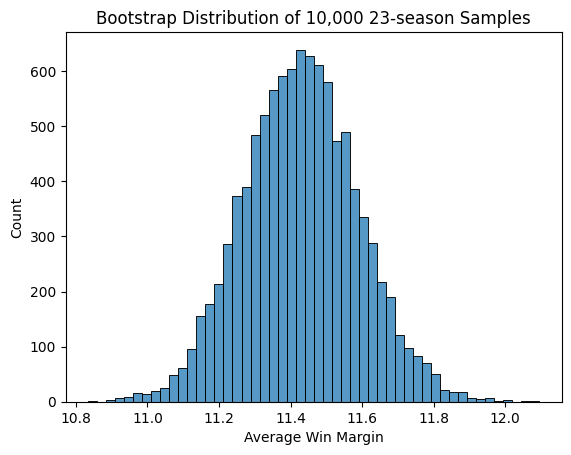

In [16]:
# Get sample means
win_margin_boot_dist = []
for i in range(10000):
	win_margin_boot_dist.append(
		# Get point estimate
		np.mean(
			# Resample
			by_season_1999_2021.sample(frac=1, replace=True)['avg_win_margin']
		)
	)

# Confirm sample means are normally distributed
g = sns.histplot(win_margin_boot_dist, bins=50)
g.set(
	xlabel="Average Win Margin",
	title="Bootstrap Distribution of 10,000 23-season Samples"
)
plt.show()

As expected, the average win margin of the bootstrap population is normally distributed. I'll perform a 1-sample T-Test to either reject or fail to reject the null hypothesis (accept the alt hypothesis).

In [17]:
# Perform 1-sample T-Test
import pingouin

pingouin.ttest(win_margin_boot_dist, by_season_2022['avg_win_margin'].iloc[0], "left")

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/parametric.py:227: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")
/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1253.59491,9999,two-sided,0.0,"[11.43, 11.43]",12.535949,inf,1.0


Based on the extremely low p-value, I can reject the null hypothesis and conclude that the average margin of victory through the first 9 weeks of the 2022 NFL season is significantly smaller than the average. I hope to add to this analysis in the future by getting more data from past NFL seasons.